<a href="https://colab.research.google.com/github/polinaproskura/NLP_ensembles/blob/main/BERT_pairs_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
! pip install datasets
! pip install transformers[torch]
! pip install bayesian-optimization
! pip install cvxopt
! pip install qpsolvers==3.4.0
! pip install accelerate==0.20.3 -U
! pip install git+https://github.com/simonzhang00/ripser-plusplus.git
! pip install git+https://github.com/IlyaTrofimov/RTD.git
clear_output()

In [2]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from sklearn.metrics import accuracy_score
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# load the data
set_seed(42)
imdb = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
clear_output()

In [5]:
def load_trainer(number, seed):
    model = AutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/results_bert_" + str(i + 1) + "/")
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    return trainer, model

In [6]:
seeds = [42, 109, 121, 122, 123]
trainers = []
models = []
for i in range(5):
    t, m = load_trainer(i, seeds[i])
    trainers.append(t)
    models.append(m)

In [7]:
dataset = tokenized_imdb["test"].train_test_split(test_size=0.5)
train, val, test = tokenized_imdb["train"], dataset['train'], dataset['test']

In [8]:
# points: accuracy -- area under rejection curve (calculate through sklearn.metrics.auc)
# 3 points for each model: maximize accuracy, minimize uncertainty 2 ways: through basic correlation and throuhg rtd features

In [10]:
import numpy as np
corr_matrix_rtd = np.genfromtxt("./gdrive/MyDrive/results_bert_1/correlation_rtd.csv", delimiter=',')
corr_matrix_res = np.genfromtxt("./gdrive/MyDrive/results_bert_1/correlation_big.csv", delimiter=',')

true_labels = np.genfromtxt("./gdrive/MyDrive/ens_predictions/true_labels.csv", delimiter=',')
single_predictions = []
for i in range(5):
    single_predictions.append(np.genfromtxt("./gdrive/MyDrive/ens_predictions/prediction_" + str(i + 1) + ".csv", delimiter=','))
single_predictions = np.array(single_predictions)

In [11]:
from sklearn.metrics import auc, accuracy_score
def accuracy_rejection(N, step, probs, true_labels, predicted_labels):
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range(step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return auc(r_rate, r_accuracy)

In [12]:
attention_weights = []
for m in models:
    attention_weights.append(m.distilbert.transformer.layer[5].attention.out_lin.weight.cpu().detach().numpy())

In [13]:
def weighted_prediction(single_predictions, weights):
    weights = weights / weights.sum()
    return np.vstack((np.dot(weights, np.array(single_predictions)[:, :, 0]), np.dot(weights, np.array(single_predictions)[:, :, 1]))).T

In [14]:
pairs = []
for i in range(5):
    for j in range(i + 1, 5):
        pairs.append([i, j])

In [1]:
def corr_based_posterior_variance(corr_matrix, weights):
    weights = np.expand_dims(weights, axis=0)
    pv = np.dot(np.dot(weights, corr_matrix), weights.T)
    return pv[0][0]

def get_corr_rtd(pair):
    crr = []
    for i in pair:
        curr_crr = []
        for j in pair:
            curr_crr.append(corr_matrix_rtd[i, j])
        crr.append(np.array(curr_crr))
    crr = np.array(crr)
    return crr

def get_corr_res(pair):
    crr = []
    for i in pair:
        curr_crr = []
        for j in pair:
            curr_crr.append(corr_matrix_res[i, j])
        crr.append(np.array(curr_crr))
    crr = np.array(crr)
    return crr

In [16]:
from bayes_opt import BayesianOptimization, UtilityFunction
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
import rtd

def black_box_function(w1, w2):
    weights = np.array([w1, w2])
    weights = weights / weights.sum()
    ensemble_predictions = np.vstack((np.dot(weights, np.array(single_predictions[pair])[:, :, 0]), np.dot(weights, np.array(single_predictions[pair])[:, :, 1]))).T
    ens_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), true_labels)
    return ens_acc

def get_opt_weights(method, pair):
    if method == 'accuracy':
        pbounds = {"w1": [0.0, 1.0], "w2": [0.0, 1.0]}
        optimizer = BayesianOptimization(f = black_box_function,
                                        pbounds = pbounds, verbose = 5,
                                        random_state = 4)
        optimizer.maximize(init_points = 5, n_iter = 100)
        ws = optimizer.max["params"]
        return ws['w1'], ws['w2']
    elif method == 'attention':
        corr_matrix = get_corr_rtd(pair)
        P = 2 * corr_matrix
        q = np.zeros_like(corr_matrix[:, :1])
        A = np.ones((1, corr_matrix.shape[0]))
        b = np.ones(1)
        lb = np.zeros(corr_matrix.shape[0])
        ub = np.ones(corr_matrix.shape[0])
        x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.array([0.2, 0.2]), solver='cvxopt', verbose=True)
        return x_sol[0], x_sol[1]
    else:
        corr_matrix = get_corr_res(pair)
        P = 2 * corr_matrix
        q = np.zeros_like(corr_matrix[:, :1])
        A = np.ones((1, corr_matrix.shape[0]))
        b = np.ones(1)
        lb = np.zeros(corr_matrix.shape[0])
        ub = np.ones(corr_matrix.shape[0])
        x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.array([0.2, 0.2]), solver='cvxopt', verbose=True)
        return x_sol[0], x_sol[1]

In [17]:
ans = []
opt_methods = ['accuracy', 'attention', 'results']
for pair in pairs:
    for opt_method in opt_methods:
        w1, w2 = get_opt_weights(opt_method, pair)
        current_predictions = weighted_prediction(np.array(single_predictions[pair]), np.array([w1, w2]))
        sigmoid = 1 / (1 + np.exp(-current_predictions))
        predicted_labels = np.argmax(sigmoid, axis=1)
        corr_matrix = get_corr_res(pair)
        ac_r = corr_based_posterior_variance(corr_matrix, np.array([w1, w2]))
        accur = accuracy_score(true_labels, predicted_labels)
        ans.append(np.array([pair, opt_method, np.array([w1, w2]), ac_r, accur]))
        print(ans[-1])

|   iter    |  target   |    w1     |    w2     |
-------------------------------------------------
| 1         | 0.9338    | 0.967     | 0.5472    |
| 2         | 0.9341    | 0.9727    | 0.7148    |
| 3         | 0.933     | 0.6977    | 0.2161    |
| 4         | 0.9329    | 0.9763    | 0.00623   |
| 5         | 0.9342    | 0.253     | 0.4348    |
| 6         | 0.9338    | 0.8726    | 0.5241    |
| 7         | 0.9346    | 0.8884    | 0.8524    |
| 8         | 0.9336    | 0.867     | 0.4392    |
| 9         | 0.9339    | 0.6963    | 0.457     |
| 10        | 0.9343    | 0.261     | 0.3801    |
| 11        | 0.9343    | 0.6042    | 1.0       |
| 12        | 0.9345    | 0.7264    | 0.8018    |
| 13        | 0.9322    | 0.0       | 0.038     |
| 14        | 0.9322    | 0.0       | 1.0       |
| 15        | 0.9346    | 0.9828    | 0.9994    |
| 16        | 0.9346    | 0.8032    | 1.0       |
| 17        | 0.9346    | 0.8945    | 0.855     |
| 18        | 0.9346    | 0.4731    | 0.5873    |


In [23]:
new_ans = []
for el in ans:
  lst = [el[0][0], el[0][1]] +  [el[1]] + [el[2][0], el[2][1]] + [np.round(el[3], 3), el[4]]
  new_ans.append(np.array(lst))
new_ans

[array(['0', '1', 'accuracy', '0.8018751575784755', '0.7278925788990013',
        '2.182', '0.9348'], dtype='<U32'),
 array(['0', '1', 'attention', '0.5', '0.5', '0.935', '0.93448'],
       dtype='<U32'),
 array(['0', '1', 'results', '0.9999906011131161', '9.398886883894646e-06',
        '0.891', '0.93288'], dtype='<U32'),
 array(['0', '2', 'accuracy', '0.602298938601075', '0.6464618570428134',
        '1.307', '0.93592'], dtype='<U32'),
 array(['0', '2', 'attention', '0.49999999999999994', '0.5', '0.84',
        '0.9352'], dtype='<U32'),
 array(['0', '2', 'results', '2.350490821494128e-06', '0.9999976495091785',
        '0.815', '0.93392'], dtype='<U32'),
 array(['0', '3', 'accuracy', '0.5053787959524341', '0.5429127018848103',
        '0.985', '0.93608'], dtype='<U32'),
 array(['0', '3', 'attention', '0.5', '0.5', '0.896', '0.936'],
       dtype='<U32'),
 array(['0', '3', 'results', '0.8340071395624671', '0.1659928604375329',
        '0.889', '0.93304'], dtype='<U32'),
 array(['0', '

In [24]:
import pandas as pd
df = pd.DataFrame(new_ans, columns=['pair1', 'pair2', 'opt_type', 'w1', 'w2', 'auc', 'acc'])
df.to_csv("./gdrive/MyDrive/results_bert_1/pair_results.csv")

In [25]:
df

,pair1,pair2,opt_type,w1,w2,auc,acc
0,0,1,accuracy,0.8018751575784755,0.7278925788990013,2.182,0.9348
1,0,1,attention,0.5,0.5,0.935,0.93448
2,0,1,results,0.9999906011131161,9.398886883894646e-06,0.891,0.93288
3,0,2,accuracy,0.602298938601075,0.6464618570428134,1.307,0.93592
4,0,2,attention,0.49999999999999994,0.5,0.84,0.9352
5,0,2,results,2.350490821494128e-06,0.9999976495091785,0.815,0.93392
6,0,3,accuracy,0.5053787959524341,0.5429127018848103,0.985,0.93608
7,0,3,attention,0.5,0.5,0.896,0.936
8,0,3,results,0.8340071395624671,0.1659928604375329,0.889,0.93304
9,0,4,accuracy,0.7293051912772587,0.7964934078762594,1.978,0.93536


Text(0, 0.5, 'Accuracy')

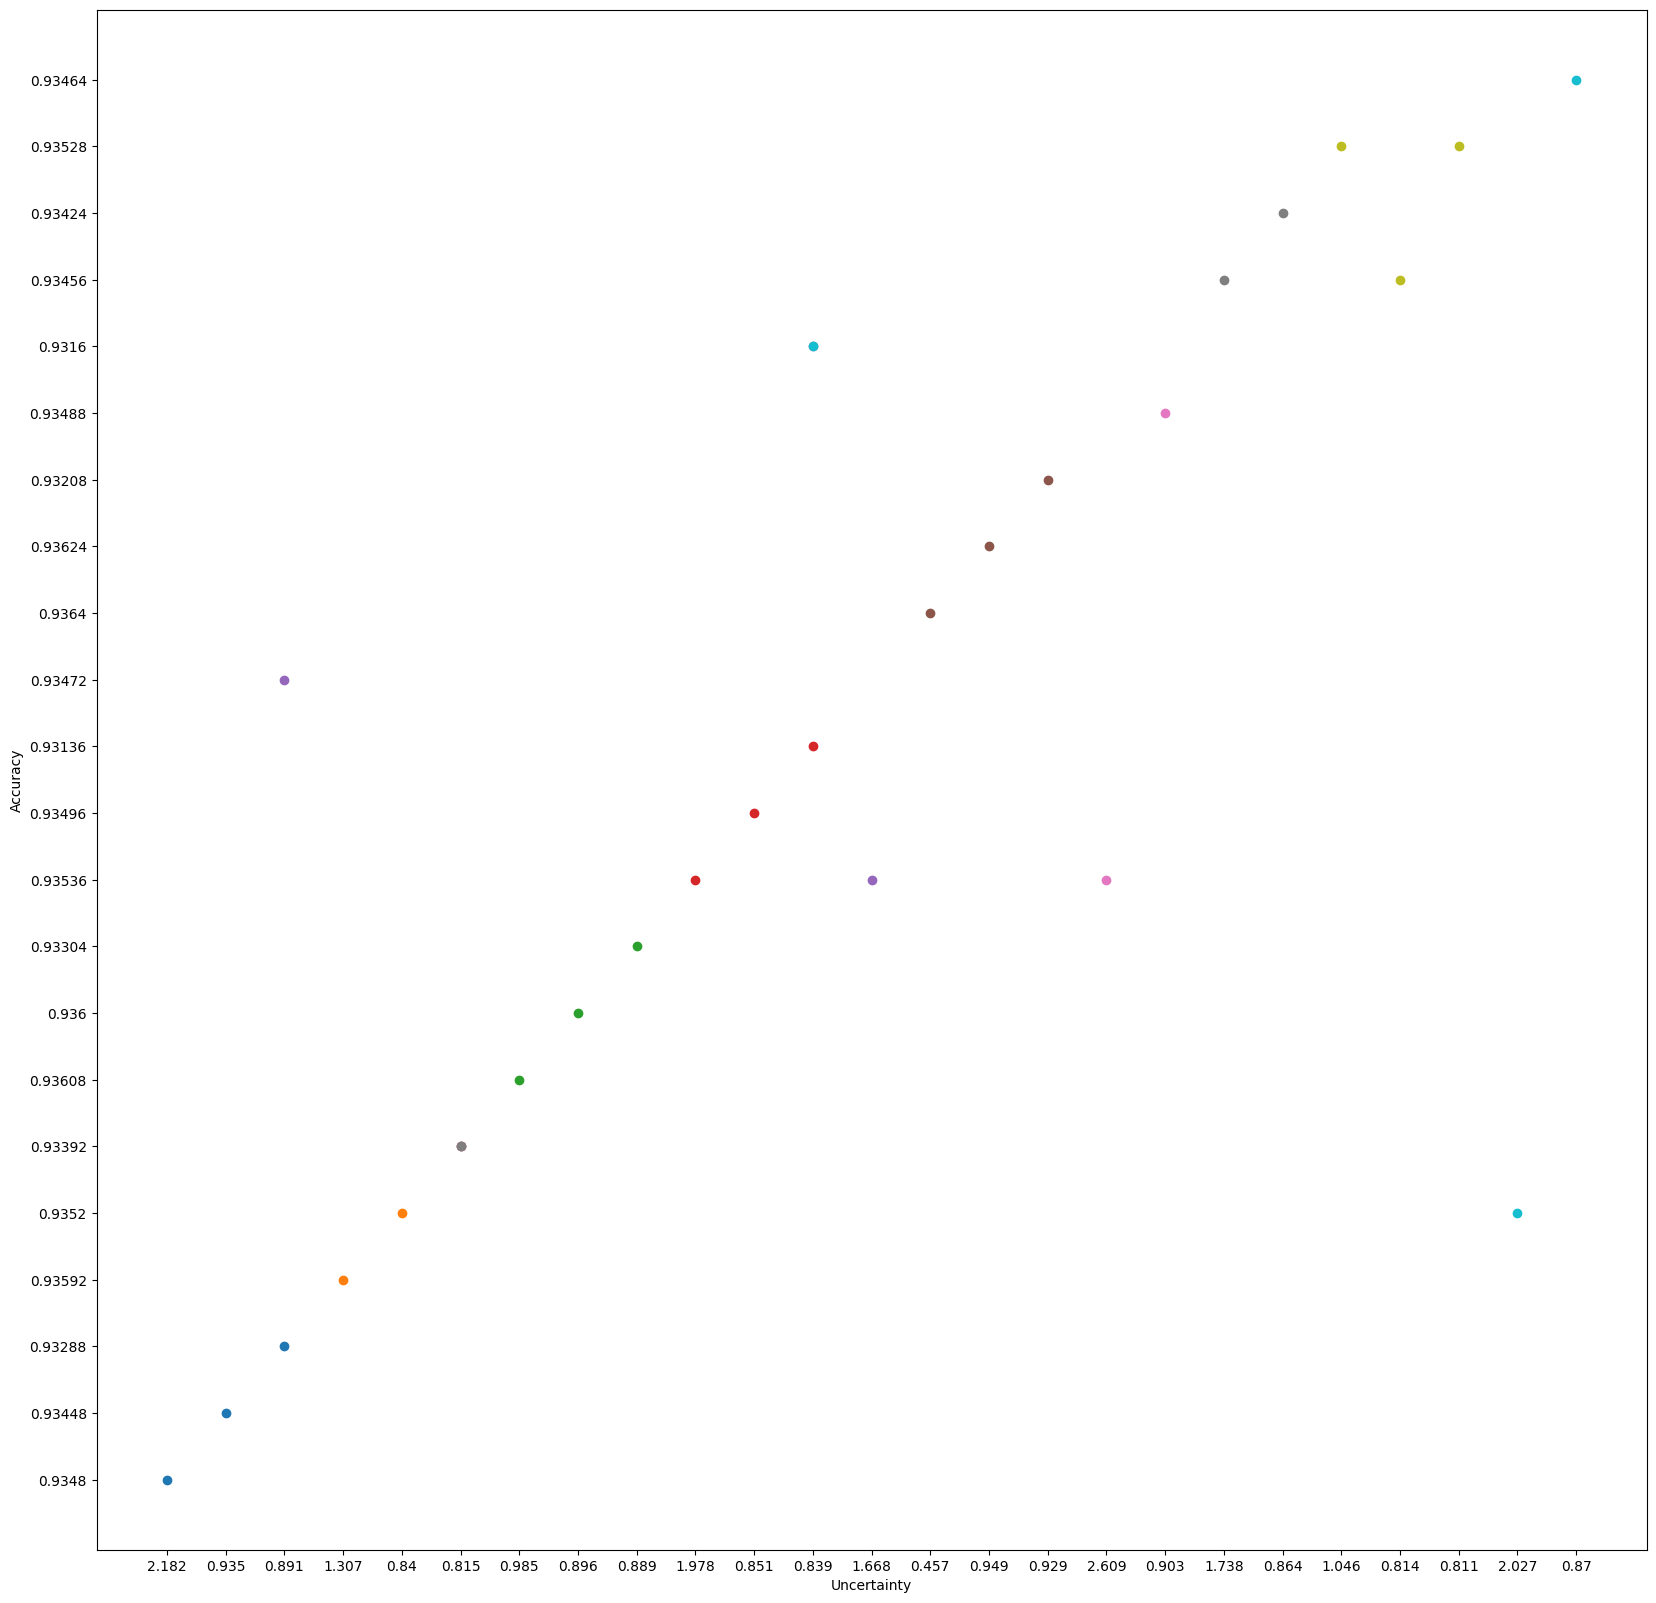

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
aucs = df.auc.values
accs = df.acc.values
for i in range(0, len(df), 3):
    plt.scatter(aucs[i:i+3], accs[i:i+3])
plt.xlabel('Uncertainty')
plt.ylabel('Accuracy')